### Group 28 members:
- Jingze Tian (CCID)
- Letian Ren (CCID)
- Essam Gouda (egouda)

# Task 1: Regression
- Linear Regression for no_of_Mosquito = function(weather_features)
- Linear Regression for no_of_Mosquito_female = function(weather_features)
- Linear Regression for no_of_Mosquito_male = function(weather_features)
- Polynomial Regression for no_of_Mosquito_female = function(weather_features)
- Polynomial Regression for no_of_Mosquito_male = function(weather_features)

#### Variations for each model:
- Different cost functions were tested
- Model without normalization and standardization, model with normalization only, model with standardization only, model with both normalization and standardization.
- Feature selection
- model statistics compared at the end

## Imports

In [1011]:
import pandas as pd
import numpy as np
import time


import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white bg for sns plots
sns.set(style="whitegrid", color_codes=True)

from sklearn.preprocessing import PolynomialF
eatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

from scipy.stats import ks_2samp

import warnings; warnings.simplefilter('ignore')

ImportError: cannot import name 'PolynomialF' from 'sklearn.preprocessing' (/home/essamgouda97/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/__init__.py)

## Read csv files (datasets)

In [ ]:
weather_data = pd.read_csv('./data/weather_data.csv')
mos_data = pd.read_csv('./data/mosquito_data_new.csv')

In [ ]:
mos_data.head()

In [ ]:
weather_data.head()

### Standardize mosquito trap date format

In [ ]:
t_list = []
for i in mos_data['Trap Date']:
    i = str(i)
    t1 = time.strptime(i,"%m/%d/%Y %H:%M:%S AM")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

mos_data['Trap Date'] = t_list

mos_data.head()

### Align date ranges in both datasets
Both datasets have different date ranges

In [1012]:
mos_data['Trap Date'] = pd.to_datetime(mos_data['Trap Date'])
start_remove = min(weather_data['date_time_local'])
end_remove = max(weather_data['date_time_local'])
mos_data_1 = mos_data.loc[(mos_data["Trap Date"] > start_remove) & (mos_data["Trap Date"] < end_remove) ]
mos_date_start = str(mos_data_1['Trap Date'].dt.date.min())
mos_date_end = str(mos_data_1['Trap Date'].dt.date.max())
mos_date_range = mos_date_start +' to ' + mos_date_end
print("Range of dates in mosquito dataset is {}".format(mos_date_range))


mos_range = (mos_data['Trap Date'] > mos_date_start) & (mos_data['Trap Date'] < mos_date_end)
mos_data = mos_data.loc[mos_range]
print(mos_data) #
mos_data = mos_data.sort_values(by='Trap Date')
mos_data #final mos_data

Range of dates in mosquito dataset is 2017-06-06 to 2018-08-21
       Trap Date         Genus Specific Epithet  Gender  Count  \
27023 2017-06-13  Ochlerotatus             spp.  Female      1   
897   2017-06-13         Culex         tarsalis  Female      1   
18715 2017-06-13  Ochlerotatus             spp.  Female      5   
9093  2017-06-13  Ochlerotatus       excrucians  Female      1   
8755  2017-06-13          Male             UnID    Male    452   
6333  2017-06-13          Male             UnID    Male    441   
8752  2017-06-13      Culiseta         inornata  Female      3   
289   2017-06-13  Ochlerotatus       Black legs  Female      1   
13818 2017-06-13          Male             UnID    Male     12   
7080  2017-06-13  Ochlerotatus       Black legs  Female      5   
17060 2017-06-13      Culiseta         inornata  Female      1   
26821 2017-06-13  Ochlerotatus          fitchii  Female     10   
13858 2017-06-13  Ochlerotatus          fitchii  Female      7   
333   2017-06

,Trap Date,Genus,Specific Epithet,Gender,Count,Trap Region,Comparison Group,Latitude,Longitude,Location
27023,2017-06-13,Ochlerotatus,spp.,Female,1,Rural-East,Outer,53.606722,-113.221359,POINT (-113.22135870000001 53.6067218)
20362,2017-06-13,Ochlerotatus,excrucians,Female,3,Outer Community-North West,Outer,53.713765,-113.959036,POINT (-113.9590359 53.7137648)
10581,2017-06-13,Ochlerotatus,spp.,Female,5,Outer Community-North East,Outer,53.774470,-113.372088,POINT (-113.3720881 53.7744701)
19780,2017-06-13,Ochlerotatus,spp.,Female,3,Rural-South West,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
19355,2017-06-13,Aedes,dorsalis,Female,3,River Valley-East-P1,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)
3425,2017-06-13,Ochlerotatus,fitchii,Female,4,River Valley-West,Core,53.504068,-113.570126,POINT (-113.5701263 53.5040684)
24507,2017-06-13,Ochlerotatus,flavescens,Female,2,Residential-North,Core,53.579459,-113.499262,POINT (-113.4992624 53.5794591)
19428,2017-06-13,Ochlerotatus,Black legs,Female,3,Rural-South West,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
2091,2017-06-13,Male,UnID,Male,62,Rural-South West,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
11132,2017-06-13,Male,UnID,Male,185,Outer Community-South1,Outer,53.333327,-113.531374,POINT (-113.5313737 53.3333269)


### Get total count for each day

In [1013]:
mos_count = mos_data.groupby(["Trap Date"]).agg({
    "Count":"sum",
})
mos_count[mos_count['Count'] == mos_count['Count'].max()]

mos_count.head() ####number of mos

,Count
Trap Date,
2017-06-13,2969
2017-06-20,1872
2017-06-27,769
2017-07-04,1779
2017-07-11,2253


In [1014]:
len(mos_count.index)

30

It can be seen that IDd and Include columns contains many NaN values so they will be dropped

In [1015]:
mos_data.isnull().sum()

Trap Date           0
Genus               0
Specific Epithet    0
Gender              0
Count               0
Trap Region         0
Comparison Group    0
Latitude            0
Longitude           0
Location            0
dtype: int64

In [1016]:
mos_data.drop(columns=['IDd', 'Include'], inplace=True)

KeyError: "['IDd' 'Include'] not found in axis"

In [ ]:
mos_data.isnull().sum()

### Select date for weather features

In [ ]:
start_date1 = '2017-05-10'#one week before 2017-05-16
end_date1 = '2017-09-26'
start_date2 = '2018-05-09'#one week before 2017-05-15
end_date2 = '2018-09-18'

Drop MST columns
Drop columns with too many NaNs
Drop unixtime columns as they are redundent
Drop wind_dir column as wind_dir_10s gives us the angle of the wind so its redundent

In [ ]:
##############Drop MST and columns with too many NaNs and unixtime##################
weather_data.drop(columns=["visibility", "cloud_cover_4", "cloud_cover_8", "cloud_cover_10", "solar_radiation", "wind_gust", "windchill", "humidex", 'unixtime', 'wind_dir'], inplace=True)
weather_data = weather_data.loc[weather_data['date_time_local'].str.contains('MDT')]

weather_data.head()

### Date selection

In [ ]:
t_list = []
for i in weather_data['date_time_local']:
    i = str(i)
    t1 = time.strptime(i,"%Y-%m-%d %H:%M:%S MDT")
    t2 = time.strftime("%Y-%m-%d", t1)
    t_list.append(t2)

weather_data['date_time_local'] = t_list
#print(weather_data)

weather_data['date_time_local'] = pd.to_datetime(weather_data['date_time_local'])
weather_range1 = (weather_data['date_time_local'] >= start_date1) & (weather_data['date_time_local'] <= end_date1)
weather_data1 = weather_data.loc[weather_range1]
weather_data1 = weather_data1.sort_values(by='date_time_local')
#print(weather_data1) 

weather_range2 = (weather_data['date_time_local'] >= start_date2) & (weather_data['date_time_local'] <= end_date2)
weather_data2 = weather_data.loc[weather_range2]
weather_data2 = weather_data2.sort_values(by='date_time_local')
#print(weather_data2) 
weather_data = weather_data1.append(weather_data2)
weather_data.head()

#### Fill NaN for weather_data

In [ ]:
weather_data.isnull().sum()

In [ ]:
len(weather_data.index)

#### To fill the NaNs we will group the weather data by day and there is 3 ways to do that for each column:
- By mean
- By mode
- By median

for each day, to do so we will need to visualize the distribution for each column and ensure that it stays similar after grouping to not add any bias to the data.

### Pressure station

In [ ]:
weather_data['pressure_station'].describe()

#### mean

In [ ]:
pressure_station_mean = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: round(x.mean(), 2)  
})

pressure_station_mean.describe()

In [ ]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['pressure_station'], pressure_station_mean['pressure_station'])

#### mode

In [ ]:
pressure_station_mode = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.value_counts().index[0]  
})

pressure_station_mode.describe()

In [ ]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['pressure_station'], pressure_station_mode['pressure_station'])

#### median

In [ ]:
pressure_station_median = weather_data.groupby('date_time_local').agg({
  'pressure_station': lambda x: x.median() 
})

pressure_station_median.describe()

In [ ]:
key_to_test = 'pressure_station'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_station_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_station_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['pressure_station'], pressure_station_median['pressure_station'])

It can be seen that for pressure station mode has the highest p-value so it will be chosen for grouping

### Pressure sea

In [ ]:
weather_data['pressure_sea'].describe()

#### mean

In [ ]:
pressure_sea_mean = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: round(x.mean(), 2)  
})

pressure_sea_mean.describe()

In [ ]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mean['pressure_sea'])

#### mode

In [ ]:
pressure_sea_mode = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.value_counts().index[0]  
})

pressure_sea_mode.describe()

In [ ]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_mode['pressure_sea'])

#### median

In [ ]:
pressure_sea_median = weather_data.groupby('date_time_local').agg({
  'pressure_sea': lambda x: x.median() 
})

pressure_sea_median.describe()

In [ ]:
key_to_test = 'pressure_sea'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = pressure_sea_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
pressure_sea_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['pressure_sea'], pressure_sea_median['pressure_sea'])

It can be seen that for pressure sea median has the highest p-value so it will be chosen for grouping

## Wind_dir_10s
This column represents the wind direction in angles so taking a mean or median doesn't make much sense and mode is expected to be the best method.

In [ ]:
weather_data['wind_dir_10s'].describe()

#### mean

In [ ]:
wind_dir_10s_mean = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: round(x.mean(), 1)  
})

wind_dir_10s_mean.describe()

In [ ]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mean['wind_dir_10s'])

#### mode

In [ ]:
wind_dir_10s_mode = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.value_counts().index[0]   
})

wind_dir_10s_mode.describe()

In [ ]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_mode['wind_dir_10s'])

#### median

In [ ]:
wind_dir_10s_median = weather_data.groupby('date_time_local').agg({
  'wind_dir_10s': lambda x: x.median()  
})

wind_dir_10s_median.describe()

In [ ]:
key_to_test = 'wind_dir_10s'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_dir_10s_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_dir_10s_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['wind_dir_10s'], wind_dir_10s_median['wind_dir_10s'])

As expected mode will be the chosen value for wind_dir_10s column as it has the highest p-value, it can be seen that mean doesn't even follow the same distribution and the median barely does follow it.

## Wind_speed

In [ ]:
weather_data['wind_speed'].describe()

#### mean

In [ ]:
wind_speed_mean = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: round(x.mean(),1)  
})

wind_speed_mean.describe()

In [ ]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['wind_speed'], wind_speed_mean['wind_speed'])

#### mode

In [ ]:
wind_speed_mode = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.value_counts().index[0]  
})

wind_speed_mode.describe()

In [ ]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['wind_speed'], wind_speed_mode['wind_speed'])

#### median

In [ ]:
wind_speed_median = weather_data.groupby('date_time_local').agg({
  'wind_speed': lambda x: x.median()  
})

wind_speed_median.describe()

In [ ]:
key_to_test = 'wind_speed'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = wind_speed_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
wind_speed_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['wind_speed'], wind_speed_median['wind_speed'])

Mode will be used for wind_speed

## Relative_humidty

In [ ]:
weather_data['relative_humidity'].describe()

#### mean

In [ ]:
relative_humidity_mean = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: round(x.mean(),1)
})

relative_humidity_mean.describe()

In [ ]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mean['relative_humidity'])

#### mode

In [ ]:
relative_humidity_mode = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.value_counts().index[0]
})

relative_humidity_mode.describe()

In [ ]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_mode['relative_humidity'])

#### median

In [ ]:
relative_humidity_median = weather_data.groupby('date_time_local').agg({
  'relative_humidity': lambda x: x.median()
})

relative_humidity_median.describe()

In [ ]:
key_to_test = 'relative_humidity'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = relative_humidity_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
relative_humidity_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['relative_humidity'], relative_humidity_median['relative_humidity'])

Grouping relative_humidty will introduce bias in the dataset so it will be ignored

## Dew_point

In [ ]:
weather_data['dew_point'].describe()

#### mean

In [ ]:
dew_point_mean = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: round(x.mean(),1)
})

dew_point_mean.describe()

In [ ]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['dew_point'], dew_point_mean['dew_point'])

#### mode

In [ ]:
dew_point_mode = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.value_counts().index[0]
})

dew_point_mode.describe()

In [ ]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['dew_point'], dew_point_mode['dew_point'])

#### median

In [ ]:
dew_point_median = weather_data.groupby('date_time_local').agg({
  'dew_point': lambda x: x.median()
})

dew_point_median.describe()

In [ ]:
key_to_test = 'dew_point'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = dew_point_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
dew_point_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['dew_point'], dew_point_median['dew_point'])

Mode will be used for dew_point

## Temperature

In [ ]:
weather_data['temperature'].describe()

#### mean

In [ ]:
temperature_mean = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: round(x.mean(),1)
})

temperature_mean.describe()

In [ ]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['temperature'], temperature_mean['temperature'])

#### mode

In [ ]:
temperature_mode = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.value_counts().index[0]
})

temperature_mode.describe()

In [ ]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['temperature'], temperature_mode['temperature'])

#### median

In [ ]:
temperature_median = weather_data.groupby('date_time_local').agg({
  'temperature': lambda x: x.median()
})

temperature_median.describe()

In [ ]:
key_to_test = 'temperature'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = temperature_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
temperature_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['temperature'], temperature_median['temperature'])

Mode will be used for temperature

## Health_index

In [ ]:
weather_data['health_index'].describe()

#### mean

In [ ]:
health_index_mean = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: round(x.mean(),1)
})

health_index_mean.describe()

In [ ]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mean[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mean[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mean data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['health_index'], health_index_mean['health_index'])

#### mode

In [ ]:
health_index_mode = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.value_counts().index[0]
})

health_index_mode.describe()

In [ ]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_mode[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_mode[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Mode data'])
ax.set(xlabel=key_to_test)

plt.show()

In [ ]:
ks_2samp(weather_data['health_index'], health_index_mode['health_index'])

#### median

In [ ]:
health_index_median = weather_data.groupby('date_time_local').agg({
  'health_index': lambda x: x.median()
})

health_index_median.describe()

In [ ]:
key_to_test = 'health_index'

plt.figure(figsize=(15, 8))
ax = weather_data[key_to_test].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
weather_data[key_to_test].plot(kind='density', color='teal')


ax = health_index_median[key_to_test].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.6)
health_index_median[key_to_test].plot(kind='density', color='orange')


ax.legend(['Original data', 'Median data'])
ax.set(xlabel=key_to_test)

plt.show()

In [1017]:
ks_2samp(weather_data['health_index'], health_index_median['health_index'])

Ks_2sampResult(statistic=0.06547619047619047, pvalue=0.20384478235583928)

Mean will be used for health_index

## Grouping weather data by date
- Pressure station by mode
- Pressure sea by median
- wind_dir_10s by mode
- wind_speed by mode
- relative_humidty ignored
- dew_point by mode
- temperature by mode
- health_index by mean

In [1018]:
weather_data_grouped = weather_data.groupby('date_time_local', as_index=False).agg({
    'pressure_station': lambda x: x.value_counts().index[0],
    'pressure_sea': lambda x: x.median(),
    'wind_dir_10s': lambda x: x.value_counts().index[0],
    'wind_speed': lambda x: x.value_counts().index[0],
    'dew_point': lambda x: x.value_counts().index[0],
    'temperature': lambda x: x.value_counts().index[0],
    'health_index': lambda x: round(x.mean(), 1)
})

print(len(weather_data_grouped.index))

weather_data_grouped.head()

273


,date_time_local,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-05-10,93.47,101.30,7.0,6.0,3.4,11.9,3.5
1,2017-05-11,93.61,101.40,11.0,6.0,5.9,7.2,3.2
2,2017-05-12,93.04,100.65,11.0,27.0,2.4,12.2,2.8
3,2017-05-13,92.37,100.40,9.0,9.0,5.3,6.3,1.8
4,2017-05-14,92.94,100.80,31.0,12.0,2.7,8.5,1.6


In [1019]:
weather_data_grouped.isnull().sum()

date_time_local     0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

## Grouping mosquito data


There are 3 candidate columns to group mosquito data by:
- Trap_date: date of trapping mosquitos
- Genus: When biologists talk about a genus, they mean one or more species of animals or plants that are closely related to each other. Low-level taxonomic ranking for biological classification.
- Specific Epithet: lowest taxonomic rank and having common characteristics and (usually) capable of mating with one another.

Add Gender for part B

In [1020]:
mos_data.head()

,Trap Date,Genus,Specific Epithet,Gender,Count,Trap Region,Comparison Group,Latitude,Longitude,Location
27023,2017-06-13,Ochlerotatus,spp.,Female,1,Rural-East,Outer,53.606722,-113.221359,POINT (-113.22135870000001 53.6067218)
20362,2017-06-13,Ochlerotatus,excrucians,Female,3,Outer Community-North West,Outer,53.713765,-113.959036,POINT (-113.9590359 53.7137648)
10581,2017-06-13,Ochlerotatus,spp.,Female,5,Outer Community-North East,Outer,53.774470,-113.372088,POINT (-113.3720881 53.7744701)
19780,2017-06-13,Ochlerotatus,spp.,Female,3,Rural-South West,Peripheral,53.528587,-113.738070,POINT (-113.7380701 53.5285872)
19355,2017-06-13,Aedes,dorsalis,Female,3,River Valley-East-P1,Core,53.581417,-113.374561,POINT (-113.3745611 53.58141700000001)


In [1021]:
mos_data_grouped = mos_data.groupby(['Trap Date'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
    'Gender': lambda x: x.value_counts().index[0]
})

print(len(mos_data_grouped.index))

mos_data_grouped.head()

30


,Trap Date,Count,Genus,Gender
0,2017-06-13,2969,Ochlerotatus,Female
1,2017-06-20,1872,Ochlerotatus,Female
2,2017-06-27,769,Ochlerotatus,Female
3,2017-07-04,1779,Ochlerotatus,Female
4,2017-07-11,2253,Ochlerotatus,Female


In [1022]:
merged_data = pd.merge(left=mos_data_grouped, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data.index))

merged_data.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data.head()

30


,Trap Date,Count,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-06-13,2969,Ochlerotatus,Female,93.08,100.90,34.0,11.0,10.2,15.1,2.6
1,2017-06-20,1872,Ochlerotatus,Female,93.12,100.90,16.0,17.0,10.0,11.0,2.4
2,2017-06-27,769,Ochlerotatus,Female,92.78,100.55,31.0,17.0,7.0,13.7,2.4
3,2017-07-04,1779,Ochlerotatus,Female,93.84,101.50,20.0,7.0,6.6,22.7,2.4
4,2017-07-11,2253,Ochlerotatus,Female,93.92,101.60,3.0,10.0,13.0,15.1,2.5


In [1023]:
merged_data.isnull().sum()

Trap Date           0
Count               0
Genus               0
Gender              0
pressure_station    0
pressure_sea        0
wind_dir_10s        0
wind_speed          0
dew_point           0
temperature         0
health_index        0
dtype: int64

## Add features
- isWarm: if temperature is above 20 = 1, else = 0.
- add genusCat for Genus
- add genderCat female = 1, male = 0
- add delta_pressure = pressure_station - pressure_sea

In [1024]:
merged_data['isWarm'] = np.where(merged_data['temperature'] >= 20, 1, 0)

In [1025]:
merged_data['Genus'] = merged_data['Genus'].astype('category')
merged_data['genusCat'] = merged_data['Genus'].cat.codes

In [1026]:
# merged_data['genderCat'] = np.where(merged_data['Gender'] == "Female", 1, 0)

In [1027]:
merged_data["delta_pressure"] = merged_data.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

In [1028]:
merged_data.head()

,Trap Date,Count,Genus,Gender,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index,isWarm,genusCat,delta_pressure
0,2017-06-13,2969,Ochlerotatus,Female,93.08,100.90,34.0,11.0,10.2,15.1,2.6,0,3,-7.82
1,2017-06-20,1872,Ochlerotatus,Female,93.12,100.90,16.0,17.0,10.0,11.0,2.4,0,3,-7.78
2,2017-06-27,769,Ochlerotatus,Female,92.78,100.55,31.0,17.0,7.0,13.7,2.4,0,3,-7.77
3,2017-07-04,1779,Ochlerotatus,Female,93.84,101.50,20.0,7.0,6.6,22.7,2.4,1,3,-7.66
4,2017-07-11,2253,Ochlerotatus,Female,93.92,101.60,3.0,10.0,13.0,15.1,2.5,0,3,-7.68


# Part A: Linear Regression for no_of_Mosquito = function(weather_features)

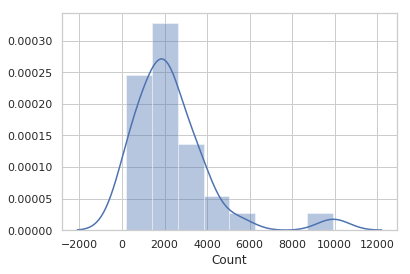

In [1029]:
sns.distplot(merged_data['Count'])

In [1030]:
merged_data['Count'].describe()

count      30.000000
mean     2303.066667
std      1903.430532
min       171.000000
25%      1050.750000
50%      1990.500000
75%      2954.750000
max      9938.000000
Name: Count, dtype: float64

In [1031]:
#merged_data = merged_data[merged_data['Count'] < merged_data['Count'].describe()['75%']]  

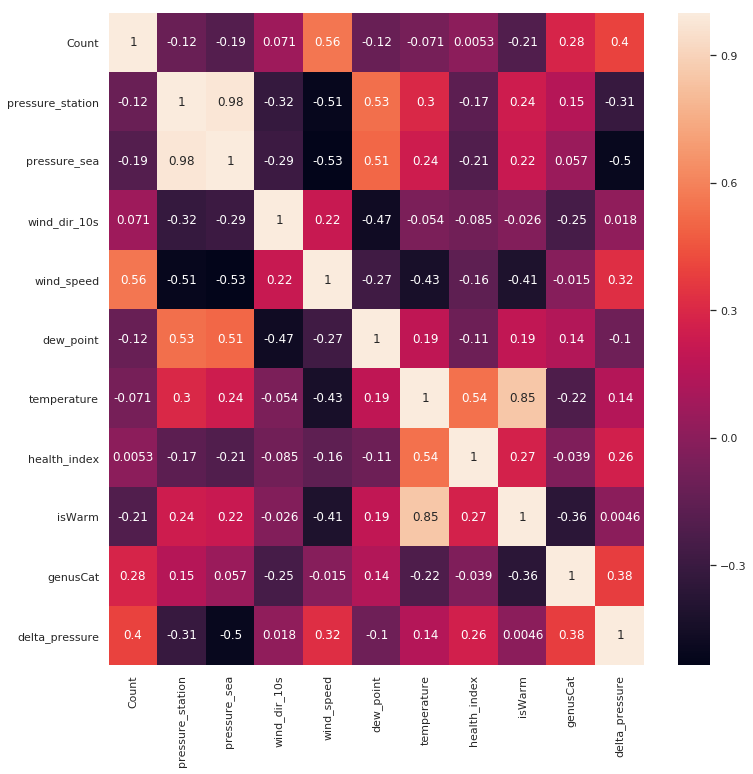

In [1032]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data.corr(), annot=True, ax=ax)

In [1033]:
x_cols = ['wind_dir_10s', 'wind_speed', 'genusCat', 'delta_pressure']
X = merged_data[x_cols]
y = merged_data['Count']

In [1034]:
from sklearn.preprocessing import StandardScaler

x_cols = ['wind_dir_10s', 'wind_speed', 'delta_pressure']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [1035]:
from sklearn.model_selection import train_test_split

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [1036]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [1037]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1038]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

13977.565749447538


,Coefficient
wind_dir_10s,0.945797
wind_speed,143.577140
genusCat,444.808211
delta_pressure,1829.649873


In [1039]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

-633.2738386103129


,Coefficient
wind_dir_10s,33.102883
wind_speed,4594.468492
genusCat,444.808211
delta_pressure,1299.051410


In [1040]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

1307.2546891033026


,Coefficient
wind_dir_10s,9.297715
wind_speed,947.995787
genusCat,444.808211
delta_pressure,271.822595


In [1041]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

1307.2546891033


,Coefficient
wind_dir_10s,9.297715
wind_speed,947.995787
genusCat,444.808211
delta_pressure,271.822595


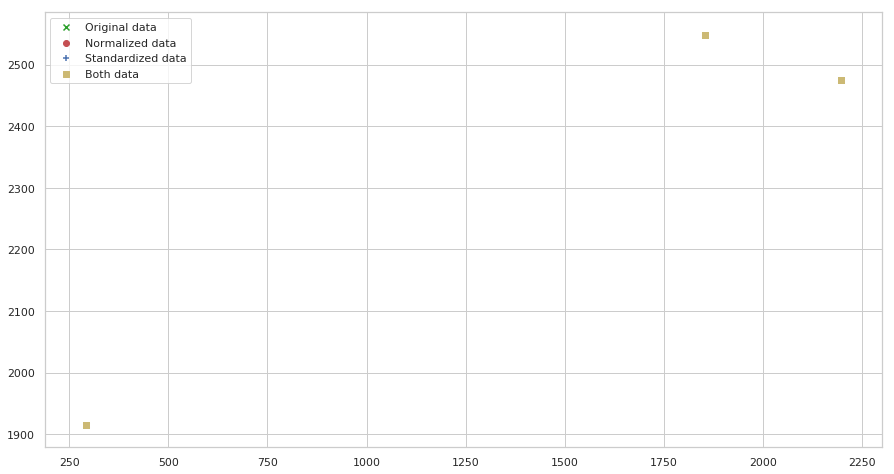

In [1042]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

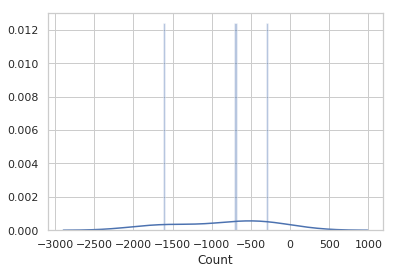

In [1043]:
sns.distplot((y_test - pred), bins=50);

In [1044]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 865.5466889907535
MSE: 1065087.2381016256
RMSE: 1032.0306381603336
R2 Square -0.5517170998839716
Train set evaluation:
_____________________________________
MAE: 1054.1758911963489
MSE: 2164515.357939524
RMSE: 1471.2291996624876
R2 Square 0.418872210493334


In [1045]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 865.5466889907522
MSE: 1065087.2381016237
RMSE: 1032.0306381603327
R2 Square -0.5517170998839687
Train set evaluation:
_____________________________________
MAE: 1054.1758911963486
MSE: 2164515.357939524
RMSE: 1471.2291996624876
R2 Square 0.418872210493334


In [1046]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 865.5466889907526
MSE: 1065087.2381016237
RMSE: 1032.0306381603327
R2 Square -0.5517170998839687
Train set evaluation:
_____________________________________
MAE: 1054.1758911963484
MSE: 2164515.3579395246
RMSE: 1471.2291996624879
R2 Square 0.4188722104933338


In [1047]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 865.546688990753
MSE: 1065087.2381016237
RMSE: 1032.0306381603327
R2 Square -0.5517170998839687
Train set evaluation:
_____________________________________
MAE: 1054.1758911963484
MSE: 2164515.3579395246
RMSE: 1471.2291996624879
R2 Square 0.4188722104933339


In [1048]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,865.546689,1.065087e+06,1032.030638,-0.551717,-92.076299
1,Linear Regression w/ norm,865.546689,1.065087e+06,1032.030638,-0.551717,-92.076299
2,Linear Regression w/ stand,865.546689,1.065087e+06,1032.030638,-0.551717,-92.076299
3,Linear Regression w/ both,865.546689,1.065087e+06,1032.030638,-0.551717,-92.076299


# Part B: count depending on Gender

In [1049]:
mos_data_grouped_B = mos_data.groupby(['Trap Date', 'Gender'], as_index=False).agg({
    'Count' : 'sum',
    'Genus': lambda x: x.value_counts().index[0],
})

print(len(mos_data_grouped_B.index))

mos_data_grouped_B.head()

60


,Trap Date,Gender,Count,Genus
0,2017-06-13,Female,1261,Ochlerotatus
1,2017-06-13,Male,1708,Male
2,2017-06-20,Female,895,Ochlerotatus
3,2017-06-20,Male,977,Male
4,2017-06-27,Female,332,Ochlerotatus


In [1052]:
mos_data_grouped_B_females = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Female"]
mos_data_grouped_B_males = mos_data_grouped_B[mos_data_grouped_B["Gender"] == "Male"]

In [1053]:
print(len(mos_data_grouped_B_females.index), len(mos_data_grouped_B_males.index))

30 30


## Linear Regression

### Females

In [1058]:
merged_data_females = pd.merge(left=mos_data_grouped_B_females, right=weather_data_grouped, left_on='Trap Date', right_on='date_time_local')

print(len(merged_data_females.index))

merged_data_females.drop(columns=['date_time_local'], inplace=True) #redundent

merged_data_females.head()

30


,Trap Date,Gender,Count,Genus,pressure_station,pressure_sea,wind_dir_10s,wind_speed,dew_point,temperature,health_index
0,2017-06-13,Female,1261,Ochlerotatus,93.08,100.90,34.0,11.0,10.2,15.1,2.6
1,2017-06-20,Female,895,Ochlerotatus,93.12,100.90,16.0,17.0,10.0,11.0,2.4
2,2017-06-27,Female,332,Ochlerotatus,92.78,100.55,31.0,17.0,7.0,13.7,2.4
3,2017-07-04,Female,1074,Ochlerotatus,93.84,101.50,20.0,7.0,6.6,22.7,2.4
4,2017-07-11,Female,1833,Ochlerotatus,93.92,101.60,3.0,10.0,13.0,15.1,2.5


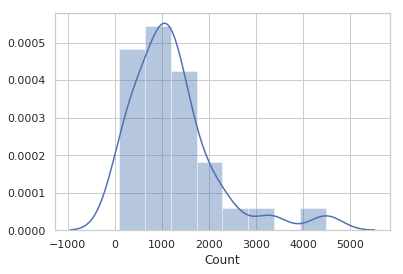

In [1059]:
sns.distplot(merged_data_females['Count'])

In [1061]:
merged_data_females['isWarm'] = np.where(merged_data_females['temperature'] >= 20, 1, 0)

In [1062]:
merged_data_females['Genus'] = merged_data_females['Genus'].astype('category')
merged_data_females['genusCat'] = merged_data_females['Genus'].cat.codes

In [1063]:
merged_data_females["delta_pressure"] = merged_data_females.apply(lambda x: x['pressure_station'] - x['pressure_sea'], axis=1)

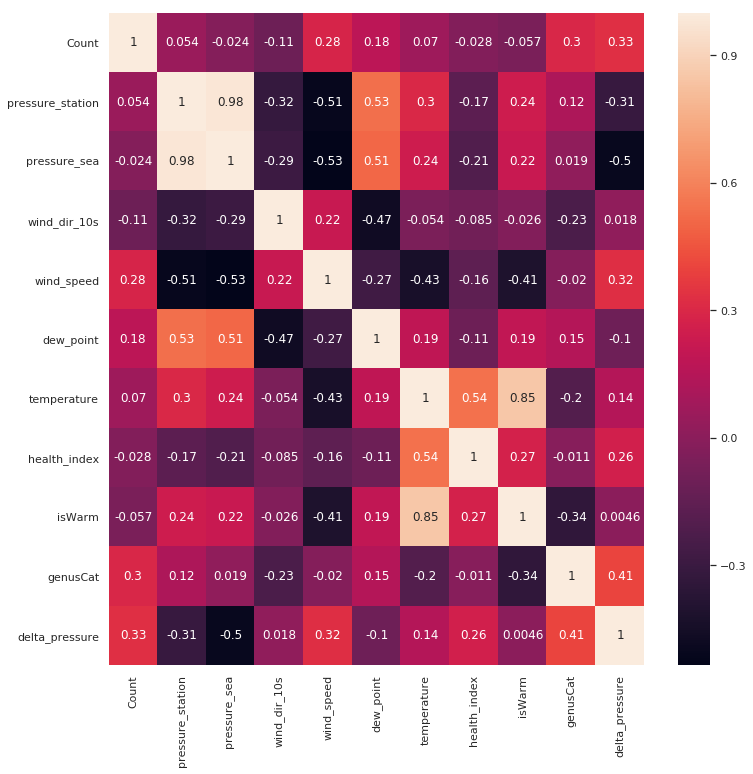

In [1064]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(merged_data_females.corr(), annot=True, ax=ax)

In [1065]:
x_cols = ['pressure_station', 'wind_speed', 'dew_point', 'temperature', 'genusCat', 'delta_pressure']
X = merged_data_females[x_cols]
y = merged_data_females['Count']

In [1067]:
from sklearn.preprocessing import StandardScaler

x_cols = ['pressure_station', 'wind_speed', 'dew_point', 'temperature', 'delta_pressure']


X_stand = X.copy()
X_norm = X.copy()
X_both = X.copy()

X_stand[x_cols] = StandardScaler().fit_transform(X[x_cols])
X_norm[x_cols] = X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_both[x_cols] = StandardScaler().fit_transform(X[x_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))[x_cols])

In [1068]:
from sklearn.model_selection import train_test_split

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train_stand, X_test_stand, y_train_stand, y_test_stand = train_test_split(X_stand, y, test_size=test_size, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=test_size, random_state=42)
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y, test_size=test_size, random_state=42)


In [1069]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [1070]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

lin_reg_norm = LinearRegression()
lin_reg_norm.fit(X_train_norm,y_train_norm)

lin_reg_stand = LinearRegression()
lin_reg_stand.fit(X_train_stand,y_train_stand)

lin_reg_both = LinearRegression()
lin_reg_both.fit(X_train_both,y_train_both)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1071]:
print(lin_reg.intercept_)
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

-18450.00444937196


,Coefficient
pressure_station,247.787415
wind_speed,66.080962
dew_point,44.189574
temperature,35.229177
genusCat,365.845861
delta_pressure,738.127921


In [1074]:
print(lin_reg_norm.intercept_)
coeff_df = pd.DataFrame(lin_reg_norm.coef_, X.columns, columns=['Coefficient'])
coeff_df

-1544.9735191021682


,Coefficient
pressure_station,716.105628
wind_speed,2114.590781
dew_point,782.155457
temperature,944.141937
genusCat,365.845861
delta_pressure,524.070824


In [1075]:
print(lin_reg_stand.intercept_)
coeff_df = pd.DataFrame(lin_reg_stand.coef_, X.columns, columns=['Coefficient'])
coeff_df

676.029765811634


,Coefficient
pressure_station,152.131428
wind_speed,436.312308
dew_point,184.888118
temperature,213.230799
genusCat,365.845861
delta_pressure,109.660241


In [1076]:
print(lin_reg_both.intercept_)
coeff_df = pd.DataFrame(lin_reg_both.coef_, X.columns, columns=['Coefficient'])
coeff_df

676.0297658116281


,Coefficient
pressure_station,152.131428
wind_speed,436.312308
dew_point,184.888118
temperature,213.230799
genusCat,365.845861
delta_pressure,109.660241


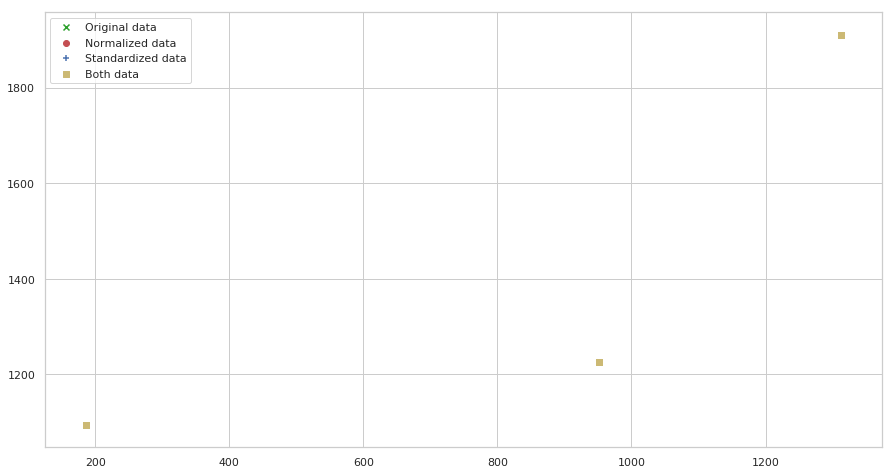

In [1077]:
pred = lin_reg.predict(X_test)
pred_norm = lin_reg_norm.predict(X_test_norm)
pred_stand = lin_reg_stand.predict(X_test_stand)
pred_both = lin_reg_both.predict(X_test_both)


plt.figure(figsize=(15, 8))
ax = plt.gca()

ax.scatter(y_test, pred, c='#2ca02c', marker='x', label='Original data')
ax.scatter(y_test_norm, pred, c='r', marker='o', label='Normalized data')
ax.scatter(y_test_stand, pred, c='b', marker='+', label='Standardized data')
ax.scatter(y_test_both, pred, c='y', marker='s', label='Both data')

plt.legend(loc='best');

plt.show()

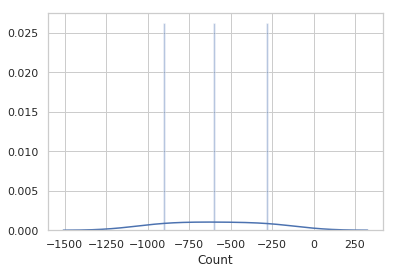

In [1078]:
sns.distplot((y_test - pred), bins=50);

In [1079]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 593.728680951271
MSE: 419739.69882783707
RMSE: 647.873212000494
R2 Square -0.9046160068056788
Train set evaluation:
_____________________________________
MAE: 538.348992818666
MSE: 625099.920147874
RMSE: 790.6326075667978
R2 Square 0.3075543257463921


In [1080]:
test_pred_norm = lin_reg_norm.predict(X_test_norm)
train_pred_norm = lin_reg_norm.predict(X_train_norm)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_norm, test_pred_norm)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_norm, train_pred_norm)

Test set evaluation:
_____________________________________
MAE: 593.7286809512716
MSE: 419739.6988278362
RMSE: 647.8732120004934
R2 Square -0.904616006805675
Train set evaluation:
_____________________________________
MAE: 538.3489928186658
MSE: 625099.9201478737
RMSE: 790.6326075667976
R2 Square 0.3075543257463924


In [1081]:
test_pred_stand = lin_reg_stand.predict(X_test_stand)
train_pred_stand = lin_reg_stand.predict(X_train_stand)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_stand, test_pred_stand)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_stand, train_pred_stand)

Test set evaluation:
_____________________________________
MAE: 593.7286809512723
MSE: 419739.69882783695
RMSE: 647.8732120004939
R2 Square -0.9046160068056783
Train set evaluation:
_____________________________________
MAE: 538.3489928186658
MSE: 625099.9201478737
RMSE: 790.6326075667976
R2 Square 0.3075543257463924


In [1082]:
test_pred_both = lin_reg_both.predict(X_test_both)
train_pred_both = lin_reg_both.predict(X_train_both)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test_both, test_pred_both)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train_both, train_pred_both)

Test set evaluation:
_____________________________________
MAE: 593.7286809512719
MSE: 419739.69882783643
RMSE: 647.8732120004935
R2 Square -0.9046160068056759
Train set evaluation:
_____________________________________
MAE: 538.3489928186659
MSE: 625099.9201478736
RMSE: 790.6326075667974
R2 Square 0.3075543257463925


In [1083]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, test_pred) , cross_val(LinearRegression())], ["Linear Regression w/ norm", *evaluate(y_test_norm, test_pred_norm) , cross_val(LinearRegression())], ["Linear Regression w/ stand", *evaluate(y_test_stand, test_pred_stand) , cross_val(LinearRegression())],["Linear Regression w/ both", *evaluate(y_test_both, test_pred_both) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,593.728681,419739.698828,647.873212,-0.904616,-22.057037
1,Linear Regression w/ norm,593.728681,419739.698828,647.873212,-0.904616,-22.057037
2,Linear Regression w/ stand,593.728681,419739.698828,647.873212,-0.904616,-22.057037
3,Linear Regression w/ both,593.728681,419739.698828,647.873212,-0.904616,-22.057037
